<a id='top'></a>
# แบบฝึกหัด Decision Tree

ในแบบฝึกหัดนี้เราจะมาเขียนโปรแกรมทำ Decision Tree ใน Python กัน

ในแบบฝึกหัด เราจะเรียนรู้เกี่ยวกับ

1. [การอ่านข้อมูลเข้าระบบ จากไฟล์ CSV](#section_1)
2. [การเตรียมข้อมูลเข้า](#section_2)
3. [การสร้าง Decision Tree โดยใช้เทคนิค CART](#section_3)
4. [การประเมินความแม่นยำของโมเดล Decision Tree ที่เราสร้าง](#section_4)

----

<a id='section_1'></a>
# 1. การอ่านข้อมูลเข้าระบบ จากไฟล์ CSV

ในแบบฝึกหัดนี้จะใช้ข้อมูลจาก http://archive.ics.uci.edu/ml/datasets/banknote+authentication

ซึ่งมีข้อมูล 5 คอลัมน์ดังนี้
1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [1]:
# Test CART on Bank Note dataset
import random
import math
import pandas as pd

random.seed(1)

อ่านข้อมูลในไฟล์แต่ละบรรทัดเข้ามาเป็น `string`

In [2]:
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', 
                 header=None)

In [3]:
print(f'ชุดข้อมูลมี : {len(data)} ตัวอย่าง')

ชุดข้อมูลมี : 1372 ตัวอย่าง


แปลงข้อมูลจาก `string` เป็น `list` ของ `float`

In [4]:
print(f'มีข้อมูล {len(set(data.iloc[:,-1]))} กลุ่ม คือ {set(data.iloc[:,-1])}')

มีข้อมูล 2 กลุ่ม คือ {0, 1}


นับจำนวนตัวอย่างในแต่ละกลุ่ม

In [5]:
print(f'มีข้อมูลกลุ่ม 0 จำนวน {sum(data.iloc[:,-1]==0)} ตัวอย่าง')
print(f'มีข้อมูลกลุ่ม 1 จำนวน {sum(data.iloc[:,-1]==1)} ตัวอย่าง')

มีข้อมูลกลุ่ม 0 จำนวน 762 ตัวอย่าง
มีข้อมูลกลุ่ม 1 จำนวน 610 ตัวอย่าง


([กลับขึ้นข้างบน](#top))

----

<a id='section_2'></a>
# 2. การเตรียมข้อมูลเข้า


แบ่งข้อมูลเป็น 2 กลุ่ม สำหรับ training และ test โดยแบ่งเป็น test data 20% และ training data 80%

In [6]:
def train_test_split(df, test_size = 0.2):
    idx_train = random.choices([True,False], weights=[1-test_size, test_size], k=len(df))
    idx_test = [not idx for idx in idx_train]
    data_train = df.iloc[idx_train,:]
    data_test = df.iloc[idx_test,:]
    return data_train, data_test

In [7]:
test_size = 0.2
train_set, test_set = train_test_split(data, test_size)

In [8]:
print(f'ข้อมูล training มี {train_set.shape[0]} ตัวอย่าง แต่ละตัวอย่างมี {train_set.shape[1]} คอลัมน์')
print(f'ข้อมูล training มี {len(set(train_set.iloc[:,-1]))} กลุ่ม คือ {set(train_set.iloc[:,-1])}')
print(f'มีข้อมูลกลุ่ม 0 จำนวน {sum(train_set.iloc[:,-1]==0)} ตัวอย่าง')
print(f'มีข้อมูลกลุ่ม 1 จำนวน {sum(train_set.iloc[:,-1]==1)} ตัวอย่าง')

print(f'ข้อมูล test มี {test_set.shape[0]} ตัวอย่าง แต่ละตัวอย่างมี {test_set.shape[1]} คอลัมน์')
print(f'ข้อมูล test มี {len(set(test_set.iloc[:,-1]))} กลุ่ม คือ {set(test_set.iloc[:,-1])}')
print(f'มีข้อมูลกลุ่ม 0 จำนวน {sum(test_set.iloc[:,-1]==0)} ตัวอย่าง')
print(f'มีข้อมูลกลุ่ม 1 จำนวน {sum(test_set.iloc[:,-1]==1)} ตัวอย่าง')

ข้อมูล training มี 1087 ตัวอย่าง แต่ละตัวอย่างมี 5 คอลัมน์
ข้อมูล training มี 2 กลุ่ม คือ {0, 1}
มีข้อมูลกลุ่ม 0 จำนวน 604 ตัวอย่าง
มีข้อมูลกลุ่ม 1 จำนวน 483 ตัวอย่าง
ข้อมูล test มี 285 ตัวอย่าง แต่ละตัวอย่างมี 5 คอลัมน์
ข้อมูล test มี 2 กลุ่ม คือ {0, 1}
มีข้อมูลกลุ่ม 0 จำนวน 158 ตัวอย่าง
มีข้อมูลกลุ่ม 1 จำนวน 127 ตัวอย่าง


([กลับขึ้นข้างบน](#top))

----

<a id='section_3'></a>
# 3. การสร้าง Decision Tree


## 3.1 Gini Index

In [9]:
# Calculate the Gini index for a split dataset
def gini_index(y_gr1, y_gr2):
    # count all samples at split point
    n_instances = float(len(y_gr1) + len(y_gr2))
    classes = set(y_gr1 + y_gr2)
    # sum weighted Gini index for each group
    gini = 0.0
    for group in [y_gr1, y_gr2]:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = group.count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [10]:
print(gini_index([1, 0], [1, 0]))

0.5


ผลลัพธ์ที่ควรจะได้

`0.5`

In [11]:
print(gini_index([0, 0], [1, 1]))

0.0


ผลลัพธ์ที่ควรจะได้

`0.0`

## 3.2 Evaluate All Split

In [12]:
def test_split(index, thr, x_train, y_train):
    left_x, left_y, right_x, right_y = list(), list(), list(), list()
    for x, y in zip(x_train, y_train):
        if x[index] <= thr:
            left_x.append(x)
            left_y.append(y)
        else:
            right_x.append(x)
            right_y.append(y)
    return left_x, left_y, right_x, right_y

In [13]:
def get_split(x_train, y_train):
    b_index, b_value, b_score, b_groups = None, None, math.inf, None
    for index in range(len(x_train[0])):
        for x, y in zip(x_train, y_train):
            groups = test_split(index, x[index], x_train, y_train)
            left_x, left_y, right_x, right_y = groups
            gini = gini_index(left_y, right_y)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, x[index], gini, groups
    return {'index':b_index, 'value':b_value, 'score':b_score, 'groups':b_groups}

In [14]:
x_sample = [[2.771244718,1.784783929],
    [1.728571309,1.169761413],
    [3.678319846,2.81281357],
    [3.961043357,2.61995032],
    [2.999208922,2.209014212],
    [7.497545867,3.162953546],
    [9.00220326,3.339047188],
    [7.444542326,0.476683375],
    [10.12493903,3.234550982],
    [6.642287351,3.319983761]]
y_sample = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
split = get_split(x_sample, y_sample)
print('Split: [X%d <= %.3f]' % ((split['index']+1), split['value']))

Split: [X1 <= 3.961]


ผลลัพธ์ที่ควรจะได้

`Split: [X1 < 6.642]`

## 3.3 Build Tree

### Terminal Node

In [15]:
# Create a terminal node value
def to_terminal(outcomes):
    return max(set(outcomes), key=outcomes.count)

In [16]:
to_terminal([0,1,1,1,1])

1

ผลลัพธ์ที่ควรจะได้

`1`

In [17]:
to_terminal([0,0,0,1,1])

0

ผลลัพธ์ที่ควรจะได้

`0`

### Recursive Splitting

In [18]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left_x, left_y, right_x, right_y = node['groups']
    del(node['groups'])
    # check for a no split
    if not left_y or not right_y:
        node['left'] = node['right'] = to_terminal(left_y + right_y)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left_y), to_terminal(right_y)
        return
    # process left child
    if len(left_y) <= min_size:
        node['left'] = to_terminal(left_y)
    else:
        node['left'] = get_split(left_x, left_y)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right_y) <= min_size:
        node['right'] = to_terminal(right_y)
    else:
        node['right'] = get_split(right_x, right_y)
        split(node['right'], max_depth, min_size, depth+1)

### Put Everything Together

In [19]:
# Build a decision tree
def build_tree(x_train, y_train, max_depth, min_size):
    root = get_split(x_train, y_train)
    split(root, max_depth, min_size, 1)
    return root

In [20]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d <= %.3f]' % ((depth*' ', (node['index']), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [21]:
x_sample = [[2.771244718,1.784783929],
    [1.728571309,1.169761413],
    [3.678319846,2.81281357],
    [3.961043357,2.61995032],
    [2.999208922,2.209014212],
    [7.497545867,3.162953546],
    [9.00220326,3.339047188],
    [7.444542326,0.476683375],
    [10.12493903,3.234550982],
    [6.642287351,3.319983761]]
y_sample = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
tree = build_tree(x_sample, y_sample, 1, 1)
print_tree(tree)

[X0 <= 3.961]
 [0]
 [1]


ผลลัพธ์ที่ควรจะได้

```
[X1 < 6.642]
 [0]
 [1]
```

In [22]:
tree = build_tree(x_sample, y_sample, 2, 1)
print_tree(tree)

[X0 <= 3.961]
 [X0 <= 2.771]
  [0]
  [0]
 [X0 <= 7.498]
  [1]
  [1]


ผลลัพธ์ที่ควรจะได้

```
[X1 < 6.642]
 [X1 < 2.771]
  [0]
  [0]
 [X1 < 7.498]
  [1]
  [1]
```

In [23]:
tree = build_tree(x_sample, y_sample, 3, 1)
print_tree(tree)

[X0 <= 3.961]
 [X0 <= 2.771]
  [X0 <= 2.771]
   [0]
   [0]
  [X0 <= 3.678]
   [0]
   [0]
 [X0 <= 7.498]
  [X0 <= 7.498]
   [1]
   [1]
  [X0 <= 9.002]
   [1]
   [1]


ผลลัพธ์ที่ควรจะได้

```
[X1 < 6.642]
 [X1 < 2.771]
  [0]
  [X1 < 2.771]
   [0]
   [0]
 [X1 < 7.498]
  [X1 < 7.445]
   [1]
   [1]
  [X1 < 7.498]
   [1]
   [1]
```

### 3.4 Prediction

In [24]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [25]:
tree = build_tree(x_sample, y_sample, 1, 1)

for x, y in zip(x_sample, y_sample):
    prediction = predict(tree, x)
    print('Expected=%d, Got=%d' % (y, prediction))

Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=1
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1


ผลลัพธ์ที่ควรจะได้

```
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
```

([กลับขึ้นข้างบน](#top))

----

<a id='section_4'></a>
# 4. การประเมินความแม่นยำของโมเดล

In [26]:
y_train = train_set.iloc[:,-1].tolist()
x_train = train_set.iloc[:,:-1].values.tolist()

In [27]:
max_depth = 2
min_size = 10
tree = build_tree(x_train, y_train, max_depth, min_size)

In [28]:
y_test = test_set.iloc[:,-1].tolist()
x_test = test_set.iloc[:,:-1].values.tolist()

In [29]:
y_pred = []
for x in x_test:
    y_pred.append(predict(tree, x))

In [30]:
assert(len(y_pred) == len(y_test))

## 4.1 Accuracy

In [31]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [32]:
accuracy_metric(y_test, y_pred)

89.82456140350877

## 4.2 Confusion Matrix

In [33]:
def confusion_matrix(actual, predicted):
    y_g = set(actual)
    y_p = set(predicted)
    mat = [[0]*len(y_p) for i in range(len(y_g))]
    for i, yg in enumerate(y_g):
        for j, yp in enumerate(y_p):
            for k in range(len(actual)):
                if actual[k] == yg and predicted[k] == yp:
                    mat[i][j] += 1
    return mat

In [34]:
def print_confusion_matrix(matrix):
    print(f'            Prediction')
    print(f'Reference {0:5d} {1:5d}')
    for i, row in enumerate(matrix):
        print(f'      {i:3d}', end=' ')
        for num in row:
            print(f'{num:5.0f}', end=' ')
        print('')

In [35]:
mat = confusion_matrix(y_test, y_pred)
print_confusion_matrix(mat)

            Prediction
Reference     0     1
        0   149     9 
        1    20   107 


## 4.3 Precision and Recall

In [36]:
def precision_recall(actual, predicted):
    tp = 0
    for y_g, y_p in zip(actual, predicted):
        tp += (y_g == 1) & (y_p == 1)
    fp = 0
    for y_g, y_p in zip(actual, predicted):
        fp += (y_g == 0) & (y_p == 1)
    fn = 0
    for y_g, y_p in zip(actual, predicted):
        fn += (y_g == 1) & (y_p == 0)
    tn = 0
    for y_g, y_p in zip(actual, predicted):
        tn += (y_g == 0) & (y_p == 0)
    
    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    return precision, recall

In [37]:
p, r = precision_recall(y_test, y_pred)
print(f'precision = {p:.3f}')
print(f'recall = {r:.3f}')

precision = 0.922
recall = 0.843


## 4.4 F1-score

In [38]:
def f1score(actual, predicted):
    p, r = precision_recall(actual, predicted)
    return (2*p*r) / (p+r)

In [39]:
f1 = f1score(y_test, y_pred)
print(f'F1-scre = {f1:.3f}')

F1-scre = 0.881


([กลับขึ้นข้างบน](#top))

----

# ใช้ Scikit-Learn

In [40]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_size)
clf = clf.fit(x_train, y_train)

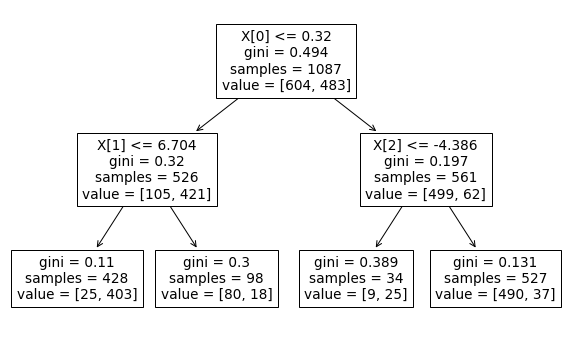

In [41]:
import sklearn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sklearn.tree.plot_tree(clf);

เทียบกับของเดิม

In [42]:
print_tree(tree)

[X0 <= 0.318]
 [X1 <= 6.676]
  [1]
  [0]
 [X2 <= -4.388]
  [1]
  [0]


In [43]:
accuracy_metric(y_test, y_pred)

89.82456140350877

In [44]:
y_pred_sklearn = clf.predict(x_test)

In [45]:
accuracy_metric(y_test, y_pred_sklearn)

89.82456140350877